In [1]:
import os
from dotenv import load_dotenv

In [2]:
load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")

## Building SQL table

In [3]:

import pandas as pd
from sqlalchemy import create_engine, Column, Integer, Float, String, MetaData, Table

def setup_database():
    df = pd.read_csv("cleaned_houses_info.csv")

    # Create SQLAlchemy engine for SQLite
    engine = create_engine('sqlite:///houses.db')

    # Define the table schema
    metadata = MetaData()

    house_listings = Table(
        'houses', metadata,
        Column('id', Integer, primary_key=True),
        Column('bedrooms', Integer),
        Column('bathrooms', Integer),
        Column('living_space', Float),
        Column('address', String),
        Column('city', String),
        Column('state', String),
        Column('zipcode', Integer),
        Column('latitude', Float),
        Column('longitude', Float),
        Column('property_url', String),
        Column('price', Float)
    )

    # Create the table in the database
    metadata.create_all(engine)

    # Insert data into the table
    df.to_sql('house_listings', engine, if_exists='append', index=False)

# Call the setup function once to create the database
setup_database()

In [4]:
import os
import json
import random
import getpass
import chromadb
import pandas as pd
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
from chromadb.utils.data_loaders import ImageLoader
from matplotlib import pyplot as plt


class ImageEmbeddingAgent:
    def __init__(self, image_dataset_path, csv_file_path) -> None:
        chroma_client = chromadb.PersistentClient(path='chroma_vectordb')
        image_loader = ImageLoader()
        multimodal_ef = OpenCLIPEmbeddingFunction()

        self.vector_db = chroma_client.get_or_create_collection(name="vector_db", embedding_function=multimodal_ef, data_loader=image_loader)
        self._load_information(image_dataset_path, csv_file_path)
        self._add_or_update_collection()

    def _load_information(self, dataset_path, csv_file_path):
        df = pd.read_csv(f'{csv_file_path}')
        column_headers = df.columns.tolist()
        self.total_num_houses = len(df)

        self.ids = []
        self.uris = []
        self.metadatas = []
        for i in range(self.total_num_houses):
            path = f'{dataset_path}/{i+1}'
            self.ids.append(str(i+1) + '_kitchen')
            self.uris.append(f'{path}_kitchen.jpg')

            self.ids.append(str(i+1) + '_bathroom')
            self.uris.append(f'{path}_bathroom.jpg')

            self.ids.append(str(i+1) + '_bedroom')
            self.uris.append(f'{path}_bedroom.jpg')

            self.ids.append(str(i+1) + '_frontal')
            self.uris.append(f'{path}_frontal.jpg')

            metadata = {}
            for j, column_name in enumerate(column_headers):
                metadata[column_name] = int(df.iloc[i, j]) if pd.api.types.is_numeric_dtype(df[column_name]) else df.iloc[i, j]
            for _ in range(4):
                self.metadatas.append(metadata)
            
    def _existing_ids(self):
        existing_ids = set()
        # Querying all existing IDs in the collection
        query_results = self.vector_db.query(
            query_texts=[""],  # Empty query to get all items
            n_results=10000,   # Adjust the number based on your expected database size
            include=['ids']
        )
        for res in query_results['ids']:
            existing_ids.update(res)
        return existing_ids

    def _add_or_update_collection(self):  # add: to add first time, update: to update
        try:
            existing_ids = self._existing_ids()
            new_ids, new_uris, new_metadatas = [], [], []
            for i in range(len(self.ids)):
                if self.ids[i] not in existing_ids:
                    new_ids.append(self.ids[i])
                    new_uris.append(self.uris[i])
                    new_metadatas.append(self.metadatas[i])
            if new_ids:
                self.vector_db.add(
                    ids=new_ids,
                    uris=new_uris,
                    metadatas=new_metadatas
                )
        except Exception as e:
            print(f"Error during update: {e}")

            
    def _show_result(self, id, query_results, i, j):
        distance = query_results['distances'][i][j]
        data = query_results['data'][i][j]
        document = query_results['documents'][i][j]
        metadata = query_results['metadatas'][i][j]
        uri = query_results['uris'][i][j]
        embeddings = query_results['embeddings'][i][j]

        print(f'id: {id}, distance: {distance}, metadata: {metadata}, document: {document}') 
        print(f'data: {uri}')
        plt.imshow(data)
        plt.axis("off")
        plt.show()


    def _filter_results(self, query_list: list, query_results: dict, ids, num_of_top_houses) -> list:
        res = []
        embeddings = {}
        ids_st = set(ids)
        already_found = set()

        num_of_items = len(query_results['ids'][0])
        for i in range(len(query_list)):
            for j in range(num_of_items):
                id = query_results["ids"][i][j].split('_')[0]
                if id in ids_st and id not in already_found:
                    already_found.add(id)
                    res.append(id)
                    num_of_top_houses -= 1
                    embedding = query_results['embeddings'][i][j]
                    embeddings[id] = embedding
                if num_of_top_houses <= 0:
                    break
        return res, embeddings

    def _multimodal_query(self, query_texts):
        query_results = self.vector_db.query(
            query_texts=query_texts,
            n_results=(self.total_num_houses * 4),
            include=['documents', 'distances', 'metadatas', 'data', 'uris', 'embeddings'],            
        )
        return query_results

    def execute_query(self, query, ids, num_top_houses=10):
        queries = [query]
        result = self._multimodal_query(queries)
        res, embeddings = self._filter_results(queries, result, ids, num_top_houses)
        return res, embeddings


if __name__ == "__main__":
    image_dataset_path = './houses_dataset/'
    csv_file_path = 'cleaned_houses_info.csv'
    agent = ImageEmbeddingAgent(image_dataset_path, csv_file_path)

Error during update: Expected include item to be one of embeddings, documents, metadatas, uris, data, distances, got ids


## Create tools

In [5]:
#SQL
from langchain_core.tools import tool

@tool("Sql_Search_tool")
def sql_search_tool(sql_query: str) -> str:
    """Executes SQL queries on an SQLite table."""
    import pandas as pd
    from sqlalchemy import create_engine

    # Create SQLAlchemy engine for SQLite
    engine = create_engine('sqlite:///houses.db')

    # Execute the SQL query
    result = pd.read_sql(sql_query, engine)

    return result

In [6]:
#CLIP
from typing import List

@tool("Image_search_tool")
def image_search_tool(query: str, ids:List[str]) -> str:
    """This tool performs a query to filter houses based on embeddings."""
    num_top_items = 10
    filtered_ids = image_embedding_agent.filter_houses(query, ids, num_top_items)
    print(f"Filtered top {num_top_items} houses IDs:", filtered_ids)
    return filtered_ids

In [7]:
#Reranker

@tool("Reranker")
class Reranker:
    """This tool reranks the CLIP image search returns by using merged SQL and CLIP queries against the CLIP image returns and its paired SQL listing data."""
    def __init__(self, model_name, record_embedder):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.record_embedder = record_embedder

    def embed_query(self, query):
        inputs = self.tokenizer(query, return_tensors="pt")
        query_embedding = self.model.get_text_features(**inputs)
        query_embedding = query_embedding.detach().numpy()
        return query_embedding

    def embed_text(self, text):
        inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        text_embedding = self.model.get_text_features(**inputs)
        text_embedding = text_embedding.detach().numpy()
        return text_embedding
    
    def rerank(self, sql_query, clip_query, sql_records, clip_image_embeddings):
        # Embed the SQL and CLIP queries
        sql_query_embedding = self.embed_query(sql_query)
        clip_query_embedding = self.embed_query(clip_query)

        # Concatenate the SQL and CLIP query embeddings
        query_embedding = np.concatenate([sql_query_embedding, clip_query_embedding], axis=1)

        # Embed the SQL records
        record_embeddings = []
        for record in sql_records:
            record_text = str(record)
            record_embedding = self.embed_text(record_text)
            record_embeddings.append(record_embedding)
            record_image_embeddings = np.array(record_image_embeddings)
        
        record_embeddings = np.array(record_embeddings)
        
        # Concatenate the record embeddings with their associated image embeddings
        record_image_embeddings = []
        for record_embedding, image_embedding in zip(record_embeddings, clip_image_embeddings):
            record_image_embeddings.append(np.concatenate([record_embedding, image_embedding], axis=1))
    
        # Calculate cosine similarity matrix
        cos_sim_matrix = cosine_similarity(query_embedding, record_image_embeddings)
    
        # Sort the results based on cosine similarity
        sorted_indices = np.argsort(cos_sim_matrix, axis=1)[:, ::-1]

        return {
            'cos_sim_matrix': cos_sim_matrix.tolist(),
            'sorted_indices': sorted_indices.tolist()}

## Helper function to create new agent worker nodes

In [8]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI


def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

## Function that creates agent nodes, it converts the agent response to a human message

In [9]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

## Create Agent Supervisor

In [10]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers.openai_functions import JsonOutputFunctionsParser

members = ["SQL_Analyst", "CLIP_Image_Searcher", "Reranker"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members
# Using openai function calling can make output parsing easier for us
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

llm = ChatOpenAI(model="gpt-4-1106-preview")

supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

## Construct Graph

In [11]:
import operator
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict
import functools

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str

#sql agent
sql_agent = create_agent(
    llm,
    [sql_search_tool],
"""You are an SQL analyst tasked with converting the user's request into an SQL query and executing it on the house_listings table.
        Take the input to search which IS present in the schema.
     Schema : house_listings = Table(
        'house_listings', metadata,
        Column('ID', Integer, primary_key=True),
        Column('bedrooms', Integer),
        Column('bathrooms', Integer),
        Column('living_space', Float),
        Column('address', String),
        Column('city', String),
        Column('state', String),
        Column('zipcode', Integer),
        Column('latitude', Float),
        Column('longitude', Float),
        Column('property_url', String),
        Column('price', Float)"""
)
sql_node = functools.partial(agent_node, agent=sql_agent, name="SQL_Analyst")

#clip agent
clip_agent = create_agent(
    llm,
    [image_search_tool],
"You analyze the property's cosmetic features using images of its bathroom, kitchen, bedroom, and front exterior."
)
clip_node = functools.partial(agent_node, agent=clip_agent, name="CLIP_Image_Searcher")

#reranker agent
reranker_agent = create_agent(
    llm,
    [Reranker],
"You will rerank the results from CLIP_Image_Searcher using the user query against the intersected and merged outputs from the SQL_Analyst and the CLIP_Image_Searcher, based on property ID."
)
reranker_node = functools.partial(agent_node, agent=reranker_agent, name="Reranker")

workflow = StateGraph(AgentState)
workflow.add_node("SQL_Analyst", sql_node)
workflow.add_node("CLIP_Image_Searcher", clip_node)
workflow.add_node("Reranker", reranker_node)
workflow.add_node("supervisor", supervisor_chain)

## Connect all the edges in the graph

In [12]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.set_entry_point("supervisor")

graph = workflow.compile()

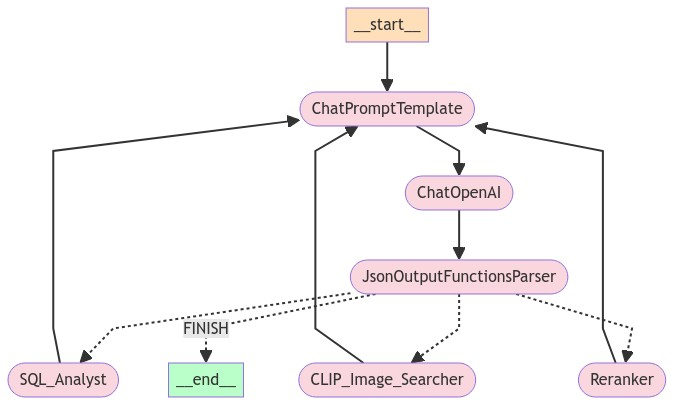

In [13]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

## Invoke the team

In [16]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="I want a house up to $500,000 with 3 bedrooms and 2 bathrooms located in the city of Anderson, California that has a kitchen with a gas range, full size refrigerator and white exterior paint.")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'SQL_Analyst'}}
----
{'SQL_Analyst': {'messages': [HumanMessage(content="To find a house meeting your criteria, I will need to search for listings with a price up to $500,000, 3 bedrooms, 2 bathrooms, located in Anderson, California. However, the specific details about the kitchen and the color of the exterior paint are not available in the given schema of the `house_listings` table. I can only filter based on the available columns, such as `price`, `bedrooms`, `bathrooms`, `city`, and `state`.\n\nHere is the SQL query that corresponds to the searchable information:\n\n```sql\nSELECT *\nFROM house_listings\nWHERE price <= 500000\n  AND bedrooms = 3\n  AND bathrooms = 2\n  AND city = 'Anderson'\n  AND state = 'CA';\n```\n\nSince I can't search for kitchen details or exterior paint color in the database, you may need to manually check these features for each listing once we have the filtered results. Would you like me to proceed with this search?", name='SQL_Analy